# DQN with Cartpole Environment using Tensorflow2.0 and TF-Agents
Reference: https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial

In [1]:
# Bit of formatting because inline code is not styled very good by default:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

In [2]:
# Get necessary libraries
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

## Step 1: Create Environment from OpenAI Gym

In the Cartpole environment:

-   `observation` is an array of 4 floats: 
    -   the position and velocity of the cart
    -   the angular position and velocity of the pole 
-   `reward` is a scalar float value
-   `action` is a scalar integer with only two possible values:
    -   `0` — "move left"
    -   `1` — "move right"

In [3]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

env.reset()
#PIL.Image.fromarray(env.render())

print("Action space: ", env.action_space.n)
print("Observation space: ", env.observation_space)

Action space:  2
Observation space:  Box(4,)


## Step 2: Convert Environment to Tensors

In [4]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Step 3: Set Hyperparameters

In [5]:
num_iterations = 15000 

initial_collect_steps = 1000 
collect_steps_per_iteration = 1  
replay_buffer_max_length = 100000 

batch_size = 64  
learning_rate = 1e-3  
log_interval = 200  

num_eval_episodes = 10  
eval_interval = 1000  

## Step 4: Define Q Network

In [6]:
fc_layer_params = (125,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

## Step 5: Initialize Agent

In [7]:
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

### Notes on Policies
Agents contain two policies: 

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.

To get an action from a policy, call the `policy.action(time_step)` method. The `time_step` contains the observation from the environment. This method returns a `PolicyStep`, which is a named tuple with three components:

-   `action` — the action to be taken (in this case, `0` or `1`)
-   `state` — used for stateful (that is, RNN-based) policies
-   `info` — auxiliary data, such as log probabilities of actions

In [8]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

## Step 6: Metrics and Evaluation

In [9]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [10]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

24.8

## Step 7: Replay Buffer

In [11]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

## Step 8: Data Collection

In [12]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

## Step 9: Train Agent

In [13]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 200: loss = 15.150442123413086
step = 400: loss = 20.40174102783203
step = 600: loss = 13.647122383117676
step = 800: loss = 13.245473861694336
step = 1000: loss = 14.415736198425293
step = 1000: Average Return = 43.599998474121094
step = 1200: loss = 122.52113342285156
step = 1400: loss = 188.23561096191406
step = 1600: loss = 288.9738464355469
step = 1800: loss = 95.9398422241211
step = 2000: loss = 139.95779418945312
step = 2000: Average Return = 22.100000381469727
step = 2200: loss = 85.24249267578125
step = 2400: loss = 121.71351623535156
step = 2600: loss = 63.47970962524414
step = 2800: loss = 48.99771499633789
step = 3000: loss = 100.18370819091797
step = 3000: Average Return = 81.30000305175781
step = 3200: loss = 52.11915969848633
step = 3400: loss = 62.45425033569336
step = 3600: loss = 56.976959228515625
step = 3800: loss = 4.921647071838379
step = 4000: loss = 5.179783821105957
step = 4000: Average Return = 48.20000076293945
step = 4200: loss = 40.803199768066406
st

## Step 10: Visualize

(-0.1300004005432136, 250.0)

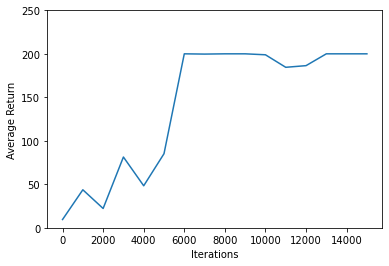

In [14]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [15]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="608" height="400" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=3, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)


create_policy_eval_video(agent.policy, "trained-agent")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [16]:
create_policy_eval_video(random_policy, "random-agent")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
